<a href="https://colab.research.google.com/github/sacktock/EDVAM-models/blob/main/RNN_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN seq2seq model for time series prediction and generation for the EDVAM dataset**

EDVAM: the first 3D eye tracking dataset for a virtual world. https://github.com/YunzhanZHOU/EDVAM

**The Problem:**

We redefine the original problem from a classification task to a regression task. We condiser the following 9 features:


*   3D point of gaze (PoG) [X, Y, Z] - 3 features.
*   Camera position [X, Y, Z] - 3 features.
*   Camera orientation vector [X, Y, Z] - 3 features.

We consider a frame as a 9-tuple of real values for each of these features. Using the EDVAM dataset which consists of time sequences of these frames collected from 63 participants, we train a RNN to predict the next m frames from a sequence of n past frames.

We formulate this sequence to sequence (seq2seq) problem with the goal of achieving long term accurate predictions of subsequent visual attention and user orientation into the future.






**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Install Dependencies**

In [ ]:
!pip install livelossplot

**Imports**

In [3]:
import pandas as pd
import numpy as np
import csv
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Hyper-params**

In [4]:
BATCH_SIZE = 128
LR = 0.0002
N_EPOCH = 50

NUM_FEATURES = 9
HIDDEN_DIM = 100
NUM_LAYERS = 2

SEQ_LEN_IN = 300 # n input frames
SEQ_LEN_OUT = 90 # m output frames

DO_SCHEDULED_SAMPLING = True
EPS = 0.2 # epsilon

**Construct the Dataset**

Using the EDVAM raw subset we construct training examples. Using a sliding window of 10 seconds (300 frames) we generate sequences of frames as training examples, the targets for our training examples are the subsequent 3 seconds worth of frames (90 frames).

In [5]:
dataset = []

# read in data from the raw EDVAM dataset
for num in range(1, 64):
  dataset.append(np.array(pd.DataFrame(pd.read_csv('drive/My Drive/EDVAM_raw_subset/'+str(num)+'.csv', header=0)).iloc[:,2:11]))

train_set = []
train_targets = []

test_set = []
test_targets = []

test_ids = [54, 40, 38, 52, 62, 58, 46, 12, 24]

for num in range(0, 63):
  if num not in test_ids:
    train_set.extend([np.array(dataset[num][i:i+SEQ_LEN_IN, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN_IN - SEQ_LEN_OUT)])
    train_targets.extend([np.array(dataset[num][i+SEQ_LEN_IN:i+SEQ_LEN_IN+SEQ_LEN_OUT, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN_IN - SEQ_LEN_OUT)])

  else:
    test_set.extend([np.array(dataset[num][i:i+SEQ_LEN_IN, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN_IN - SEQ_LEN_OUT)])
    test_targets.extend([np.array(dataset[num][i+SEQ_LEN_IN:i+SEQ_LEN_IN+SEQ_LEN_OUT, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN_IN - SEQ_LEN_OUT)])

train_set = np.array(train_set)
train_targets = np.array(train_targets)

test_set = np.array(test_set)
test_targets = np.array(test_targets)

**Visualizing Time Sequences**

Let's visualize some time sequences from the test data by plotting them on 3D axes. 

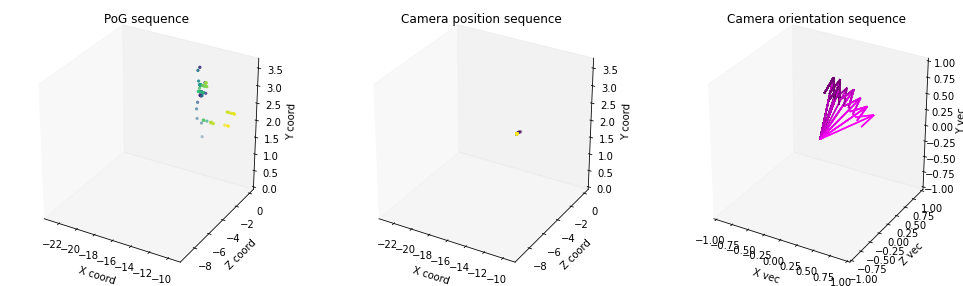

In [6]:
def plot_seq(arr): # requires non-normalized data
  seq_len = arr.shape[0]

  # PoG (x, y, z)
  x_p = arr[:, 0]
  y_p = arr[:, 1]
  z_p = arr[:, 2]

  # Camera pos (x, y, z)
  x_c = arr[:, 3]
  y_c = arr[:, 4]
  z_c = arr[:, 5]

  # Camera vec (x, y, z)
  x_o = arr[:, 6]
  y_o = arr[:, 7]
  z_o = arr[:, 8]
  
  fig = plt.figure(figsize=(17, 5))

  ax = fig.add_subplot(1,3,1, projection='3d')

  ax.set_title("PoG sequence")
  ax.set_xlabel("X coord")
  ax.set_ylabel("Z coord")
  ax.set_zlabel("Y coord")

  ax.set_xlim(-23.4, -9)
  ax.set_zlim(0,3.7)
  ax.set_ylim(-9.7,0.4)

  ax.grid(False)
  ax.scatter(x_p,z_p,y_p, c=np.arange(seq_len, seq_len*2), marker='.')

  ax = fig.add_subplot(1,3,2, projection='3d')

  ax.set_title("Camera position sequence")
  ax.set_xlabel("X coord")
  ax.set_ylabel("Z coord")
  ax.set_zlabel("Y coord")

  ax.set_xlim(-23.4, -9)
  ax.set_zlim(0,3.7)
  ax.set_ylim(-9.7,0.4)

  ax.grid(False)
  ax.scatter(x_c,z_c,y_c, c=np.arange(seq_len, seq_len*2), marker='.')

  ax = fig.add_subplot(1,3,3, projection='3d')

  ax.set_title("Camera orientation sequence")
  ax.set_xlabel("X vec")
  ax.set_ylabel("Z vec")
  ax.set_zlabel("Y vec")

  ax.set_xlim(-1, 1)
  ax.set_zlim(-1,1)
  ax.set_ylim(-1,1)

  ax.grid(False)
  # visualize camera orientations as unit vectors
  ax.quiver(np.zeros_like(90,), np.zeros_like(90,), np.zeros_like(90,), x_o, y_o, z_o, 
            colors=[(col, 0, col) for col in np.arange(0,1.0,step=(1/seq_len))])

  plt.show()

idx = np.random.choice(test_ids)
start = np.random.randint(0, dataset[idx].shape[0] - SEQ_LEN_OUT)

plot_seq(np.array([dataset[idx][start+i, :] for i in range(SEQ_LEN_OUT)]))

**Normalize the Data**

We normalize the data so that no feature takes priority over the other when training the network.

In [7]:
means = np.array([[[-14.36113819,   1.6289878,   -4.3960396,  -16.36456295,   1.71260748,
                     -4.05706022,   0.49849881,  -0.03998035,  -0.03879195]]], dtype=np.float32)

stds = np.array([[[4.03698547, 0.8635303,  2.79440592, 2.69018196, 0.06613871, 1.5993084,
                   0.65815014, 0.17796627, 0.54445267]]], dtype=np.float32)

 # normalize both datasets using pre-computed means and stds
train_set = (train_set - means) / stds
train_targets = (train_targets - means) / stds

test_set = (test_set - means) / stds
test_targets = (test_targets - means) /stds

**Setup the Dataloaders**

In [8]:
# wrap data in tensors and init data loaders
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

train_data = TensorDataset(torch.from_numpy(train_set), torch.from_numpy(train_targets))
test_data = TensorDataset(torch.from_numpy(test_set), torch.from_numpy(test_targets))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

test_iter = iter(cycle(test_loader))

**Define the Model**

To implement the recurrent neural network (RNN) we use gated recurrent units (GRUs). We use the Encoder-Decoder model architecture that has been successful for Image Captioning, NLP, and some real valued tasks. 

The Encoder processes the sequence input through 2 layers of GRUs at each timestep and constructs a context vector which is then fed to the Decoder. The Decoder passes the context vector (last Encoder state) as input and outputs m predicted frames. We use just a single GRU cell fitted with a linear output layer to implement the Decoder.

The best parameters that we found are as follows:

*   Hidden size = 100
*   Number of (Encoder) GRU layers = 2
*   Dropout = 0.4
*   Epsilon = 0.2

In [9]:
class DecoderCell(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, dropout=0.4):
      super().__init__()
      self.cell = nn.GRUCell(input_size, hidden_dim)
      self.out = nn.Linear(hidden_dim, output_size)
      self.dropout = nn.Dropout(dropout)

      self.init_weights()

  def init_weights(self):
    initrange = 0.1
    self.out.bias.data.zero_()
    self.out.weight.data.uniform_(-initrange, initrange)

  def forward(self, prev_hidden, y):
    hidden = self.cell(y, prev_hidden)
    output = self.out(hidden)
    return output, self.dropout(hidden)

class RNNEncoderDecoder(nn.Module):

  def __init__(self, input_size, output_size, hidden_dim, num_layers, dropout=0.4):
    super().__init__()    
    self.output_size = output_size
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.encoder = nn.GRU(input_size, hidden_dim, num_layers, dropout=dropout, batch_first=True)
    self.decoder = DecoderCell(input_size, output_size, hidden_dim)

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device)
    return hidden

  def forward(self, x, future=0, y=None):
    x = x.float()
    batch_size = x.shape[0]

    hidden = self.init_hidden(batch_size)

    # pass the input sequence through the encoder to get the context vector
    encoder_out, encoder_hidden = self.encoder(x, hidden)
    
    # context vector for Decoder input
    prev_hidden = encoder_hidden[-1]

    outputs = []

    # we need to pass an input frame into the Decoder to start decoding
    y_prev = x[:, -1]

    # we Decode some sequences in Teacher Forcing mode with probability epsilon
    mask = torch.cuda.FloatTensor(batch_size).uniform_() < EPS
    mask = mask.view(-1,1)
    mask = mask.repeat_interleave(9, dim=1)    

    for i in range(future):
      # if targets are provided apply the mask
      if (y is not None) and (i > 0) and (DO_SCHEDULED_SAMPLING):
        y_prev = y_prev.masked_fill(mask, 0) + y[:, i-1].masked_fill(~mask, 0)
      # else pass the previous output as input into the decoder
      decoder_out, prev_hidden = self.decoder(prev_hidden, y_prev)
      y_prev = decoder_out
      outputs += [decoder_out]

    outputs = torch.stack(outputs, 1)
    return outputs

input_size = NUM_FEATURES
output_size = NUM_FEATURES

model = RNNEncoderDecoder(input_size, output_size, HIDDEN_DIM, NUM_LAYERS).to(device)
optim = torch.optim.Adam(model.parameters(), lr=LR, amsgrad=True)
liveplot = PlotLosses()

**Define the Criterion**

We won't train with MSE loss (as with typical regerssion tasks) instead we will introduce a different loss term called "frame loss". Our objective is to minimze the PoG error, camera position error, and camera orientation error by calculating the 3D distance between the target frames and the predicted frames. 

Note: training with nn.MSELoss was much more unstable and had a worse convergence.

In [10]:
class frame_loss(nn.Module):
  def __init__(self):
    super(frame_loss, self).__init__()
 
  def forward(self, inputs, targets):
    # sum of geometric error for PoGs
    loss = torch.sqrt(torch.square(targets[:, :, 0:3] - inputs[:, :, 0:3]).sum(axis=2)).sum()
    # sum of geometric error for camera pos
    loss += torch.sqrt(torch.square(targets[:, :, 3:6] - inputs[:, :, 3:6]).sum(axis=2)).sum()
    # sum of geometric error for camera orientation
    loss += torch.sqrt(torch.square(targets[:, :, 6:9] - inputs[:, :, 6:9]).sum(axis=2)).sum()
        
    return loss

**Training Code**

We will use a simple variant of "Scheduled Sampling" to train the RNN. With "Scheduled Sampling" we flip a coin for each sequence and decode it in "Teacher Forcing" mode (using the provided targets)  with probability epsilon and in "Inference" mode (using the output of the Decoder as input) otherwise. 

We monitor the training (frame) loss and the valdiation (mse) loss (in "Inference" mode).

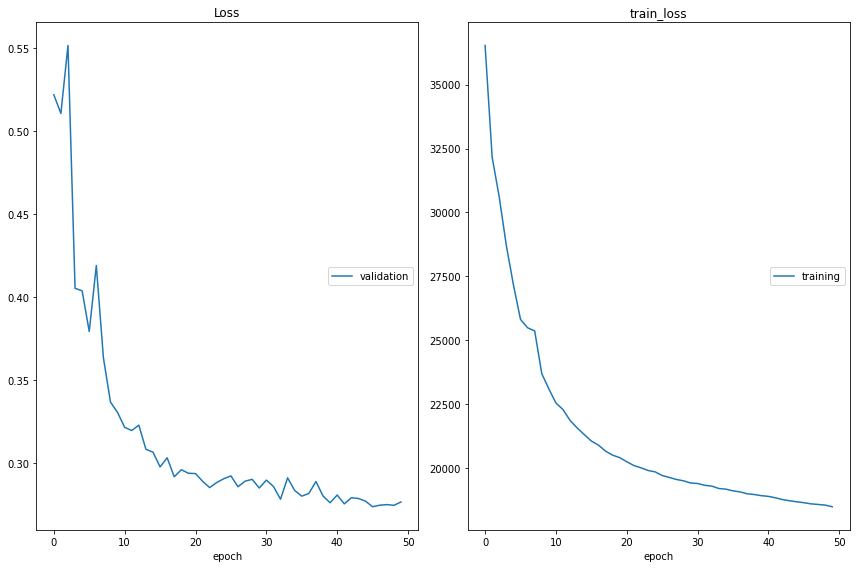

Loss
	validation       	 (min:    0.274, max:    0.552, cur:    0.276)
train_loss
	training         	 (min: 18489.735, max: 36529.948, cur: 18489.735)
Epoch 50/50, train_loss: 18489.734607, val_loss: 0.276435, best_val_loss: 0.273577, best_epoch: 46


In [11]:
step = 0
best_val_loss = np.inf
best_epoch = 0

while (step < N_EPOCH):

  loss_arr = np.zeros(0)
  val_loss_arr = np.zeros(0)

  model.train()
  
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs, future=SEQ_LEN_OUT, y=targets)

    loss = frame_loss()(outputs, targets)

    # parameter update step
    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_arr = np.append(loss_arr, loss.item())

  model.eval()

  with torch.no_grad():
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)

      outputs = model(inputs, future=SEQ_LEN_OUT)
      
      val_loss = nn.MSELoss()(outputs, targets)

      val_loss_arr = np.append(val_loss_arr, val_loss.item())

  step += 1

  val_losses = val_loss_arr.mean()
  train_losses = loss_arr.mean()

  if val_losses < best_val_loss:
    best_epoch = step
    best_val_loss = val_losses
    torch.save({'model':model.state_dict()}, 'drive/My Drive/training/RNN_seq2seq.chkpt')

  liveplot.update({"train_loss" : train_losses, "val_loss" : val_losses})
  liveplot.send()

  print('Epoch {}/{}, train_loss: {:.6f}, val_loss: {:.6f}, best_val_loss: {:.6f}, best_epoch: {}'.format(step, N_EPOCH, train_losses,val_losses, best_val_loss, best_epoch))

**Model Validation**

Let's load out best model and see how well it does on unseen data in "Inference" mode.

In [12]:
try:
  params = torch.load('drive/My Drive/training/RNN_seq2seq.chkpt')
  model.load_state_dict(params['model'])
except:
  print('Failed to load best model ... using current model')

model.eval()

val_loss_arr = np.zeros(0)

with torch.no_grad():
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs, future=SEQ_LEN_OUT)
      
    val_loss = nn.MSELoss()(outputs, targets) 

    val_loss_arr = np.append(val_loss_arr, val_loss.item())

print('val loss {:.6f}'.format(val_loss_arr.mean()))

val loss 0.273577


# Evaluate the model

Let's load our model and have a look at some regression metrics and accuracy scores for each of the features.

In [13]:
model.eval()

futures = [1, 5, 10, 45, 90] # how good is the model at predicting into the future

df_m = pd.DataFrame(index=["PoG X", "PoG Y", "PoG Z", "Cam X", "Cam Y", "Cam Z", "Cam Vec X", "Cam Vec Y", "Cam Vec Z"])
df_p = pd.DataFrame(index=["<.5m","<1m", "<2m", "<5m"])
df_c = pd.DataFrame(index=["<.5m","<1m", "<2m", "<5m"])
df_v = pd.DataFrame(index=["<1 deg", "<5 deg", "<10 deg", "<30 deg"])

for future in futures:
  actual, predicted = [], []

  with torch.no_grad():
    for idx in test_ids:
      for start in range(0, dataset[idx].shape[0] - SEQ_LEN_IN - BATCH_SIZE - future, BATCH_SIZE):

        inputs = np.array([np.array(dataset[idx][start+i:start+i+SEQ_LEN_IN, :], dtype=np.float32) for i in range(BATCH_SIZE)])
        targets = np.array([np.array(dataset[idx][start+i+SEQ_LEN_IN+future-1, :], dtype=np.float32) for i in range(BATCH_SIZE)])

        # transform input
        inputs = (inputs - means) / stds
        inputs = torch.tensor(inputs).to(device)

        outputs = model(inputs, future=future)
        outputs = outputs[:, -1].data.cpu().numpy() # we only care about the last frame prediction

        # inverse transform output
        predicted += (outputs * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)).tolist()

        actual += targets.tolist()

  actual, predicted = np.array(actual), np.array(predicted)

  N = actual.shape[0]

  # point of gaze accuracy measures (in meters)
  pog_error = np.sqrt(np.square(actual - predicted)[:, 0:3].sum(axis=1))
  pog_accuracy = [100 * np.array([1 if error < dist else 0 for error in pog_error]).sum() / N for dist in [.5, 1., 2., 5.]]

  # camera position accuracy measures (in meters)
  cam_error = np.sqrt(np.square(actual - predicted)[:, 3:6].sum(axis=1))
  cam_accuracy = [100 * np.array([1 if error < dist else 0 for error in cam_error]).sum() / N  for dist in [.5, 1., 2., 5.]]

  # camera orientation error (in degrees)
  vec_error = np.arccos((actual[:, 6] * predicted[:, 6] + actual[:, 7] * predicted[:, 7] + actual[:, 8] * predicted[:, 8])
              / (np.sqrt(actual[:, 6]**2 + actual[:, 7]**2 + actual[:, 8]**2) * np.sqrt(predicted[:, 6]**2 + predicted[:, 7]**2 + predicted[:, 8]**2)))
  # convert from radians to degrees
  vec_error = vec_error * 180 / np.pi
  vec_error = [100 * np.array([1 if error < angle else 0 for error in vec_error]).sum() / N  for angle in [1., 5., 10., 30.]]

  # regression metrics
  MSE = (np.square(actual - predicted)).mean(axis=0) # mean squared error
  MAE = (np.abs(actual - predicted)).mean(axis=0) # mean absolute error
                    
  # adjusted R squared correlation coeff for multiple regression
  # each feature is dependent on each feature, but some features are correlated
  N = predicted.shape[0]
  k = predicted.shape[1]
  adj_R2 = []
  corr_matrix = np.corrcoef(predicted, rowvar=False)
  for i in range(k):
    corr_yi = np.corrcoef(predicted, actual[:, i], rowvar=False)
    corr_vec = [corr_yi[j][9] for j in range(k)]

    R2 = np.dot(np.dot(corr_vec, np.linalg.inv(corr_matrix)), corr_vec)

    adj_R2 += [1 - (1 - R2)*((N - 1) / (N - k - 1))]

  df = pd.DataFrame({"MSE" : MSE, "MAE" : MAE, "adj R2" : adj_R2}, 
                    index=["PoG X", "PoG Y", "PoG Z", "Cam X", "Cam Y", "Cam Z", "Cam Vec X", "Cam Vec Y", "Cam Vec Z"])
  df_m = pd.concat([df_m, df], axis=1)

  df = pd.DataFrame({"PoG accuracy" : pog_accuracy}, index=["<.5m", "<1m", "<2m", "<5m"])
  df_p = pd.concat([df_p, df], axis=1)

  df = pd.DataFrame({"Camera accuracy": cam_accuracy}, index=["<.5m", "<1m", "<2m", "<5m"])
  df_c = pd.concat([df_c, df], axis=1)

  df = pd.DataFrame({"Camera vec accuracy" : vec_error}, index=["<1 deg", "<5 deg", "<10 deg", "<30 deg"])
  df_v = pd.concat([df_v, df], axis=1)

**Model prediction metrics**

In [14]:
pd.set_option("display.precision", 5)
df_m.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['MSE', 'MAE', 'R2']])
display(df_m)

1 futures                    ... 90 futures                  
                MSE      MAE       R2  ...        MSE      MAE       R2
PoG X       0.82850  0.41217  0.96165  ...    8.99115  2.22310  0.58230
PoG Y       0.13188  0.13743  0.86570  ...    0.80661  0.70800  0.20737
PoG Z       0.36165  0.37851  0.96460  ...    3.95664  1.43894  0.60876
Cam X       0.00744  0.06671  0.99919  ...    1.30474  0.83543  0.85763
Cam Y       0.00003  0.00147  0.90637  ...    0.00032  0.00729  0.08111
Cam Z       0.00410  0.04709  0.99904  ...    0.69338  0.58957  0.80520
Cam Vec X   0.00134  0.02698  0.99804  ...    0.20458  0.28267  0.67457
Cam Vec Y   0.00021  0.00634  0.99321  ...    0.01977  0.09600  0.39605
Cam Vec Z   0.00179  0.03120  0.99687  ...    0.16167  0.27768  0.61984

[9 rows x 15 columns]

**Model prediction accuracy for PoG in 3D world coordinates**

In [15]:
pd.set_option("display.precision", 2)
df_p.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['PoG accuracy']])
display(df_p)

,1 futures,5 futures,10 futures,45 futures,90 futures
,PoG accuracy,PoG accuracy,PoG accuracy,PoG accuracy,PoG accuracy
<.5m,58.61,26.24,13.74,3.09,1.58
<1m,84.62,56.48,40.23,17.26,10.95
<2m,94.98,85.24,75.39,48.93,35.87
<5m,98.43,97.20,96.64,92.25,83.31


**Model prediction accuracy for Camera position in 3D world coordinates**

In [16]:
df_c.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['Camera position accuracy']])
display(df_c)

,1 futures,5 futures,10 futures,45 futures,90 futures
,Camera position accuracy,Camera position accuracy,Camera position accuracy,Camera position accuracy,Camera position accuracy
<.5m,100.0,97.01,87.52,43.69,23.06
<1m,100.0,99.47,98.06,78.70,50.72
<2m,100.0,100.00,100.00,96.87,87.61
<5m,100.0,100.00,100.00,100.00,99.68


**Model prediction accuracy for 3D camera orientation**

In [17]:
df_v.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['Camera vec accuracy']])
display(df_v)

,1 futures,5 futures,10 futures,45 futures,90 futures
,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy
<1 deg,36.69,16.74,10.87,2.96,0.39
<5 deg,93.40,73.97,59.67,23.21,14.16
<10 deg,99.91,93.73,83.80,46.96,29.09
<30 deg,100.00,99.99,99.46,82.91,67.95


# Having a closer look

While our model has worse next frame prediction (than the frame prediction model) it has signifigantly better accuracy into the future accross the board.

**Sequence Generation:**

Using the model let's generate a sequence in "Inference" mode (without targets) to see if the model has indeed learned longer term dependencies / patterns.

The following code passed 300 frames of unseen test data and generates 90 frames into the future.

In [18]:
future = SEQ_LEN_OUT

# get a random test sequence from the test data
idx = np.random.choice(test_ids)
start = np.random.randint(0, dataset[idx].shape[0] - SEQ_LEN_IN - future)

inputs = np.array(dataset[idx][start:start+SEQ_LEN_IN, :], dtype=np.float32)
targets = np.array(dataset[idx][start+SEQ_LEN_IN:start+SEQ_LEN_IN+future, :], dtype=np.float32)

# transform input
inputs = (inputs - means) / stds
inputs = torch.tensor(inputs).to(device)

outputs = model(inputs, future=future)

gen_seq = outputs.squeeze(0).data.cpu().numpy()

# cut the first bit of the sequence
actual_seq = targets

# inverse transform the generated sequence
gen_seq = gen_seq * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)

**Plot the 3D point clouds and vectors**

Ground truth:

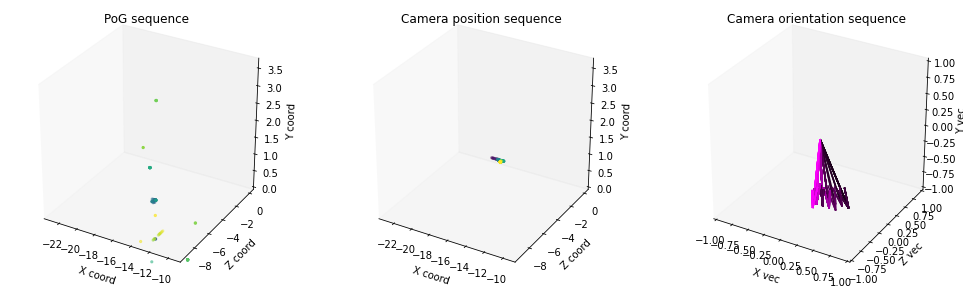

In [19]:
plot_seq(actual_seq)

Generated sequence:

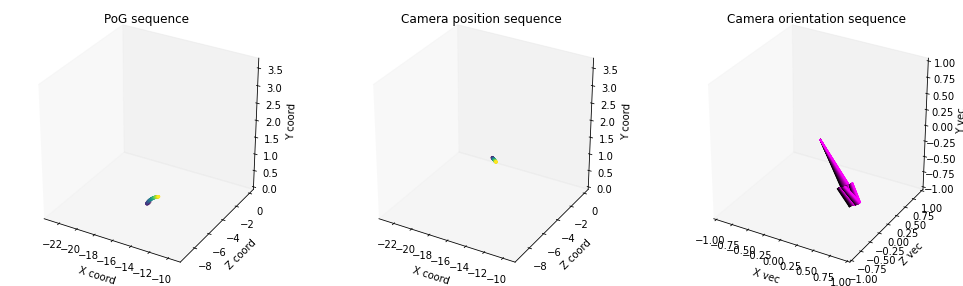

In [20]:
plot_seq(gen_seq)

**Line plots for each of the 9 features:**

Let's plot the ground truth sequence against the generated sequence for each of the 9 features and see if we got close.

PoG X:

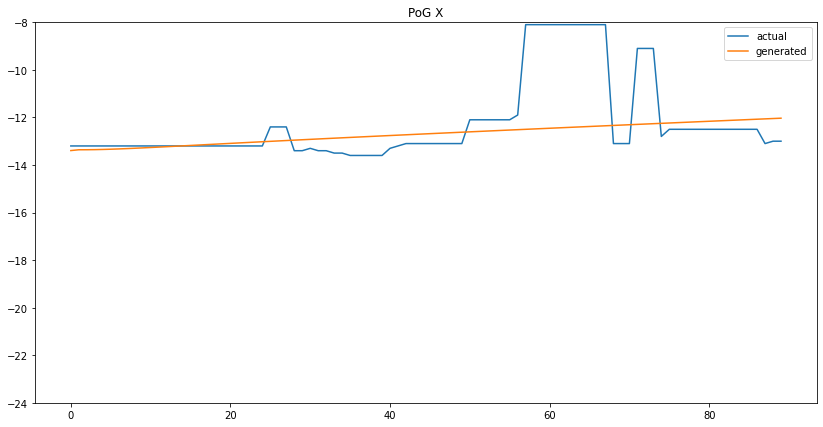

In [21]:
df = pd.DataFrame({"actual" : actual_seq[:,0].tolist(), "generated" : gen_seq[:,0].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="PoG X")

PoG Y:

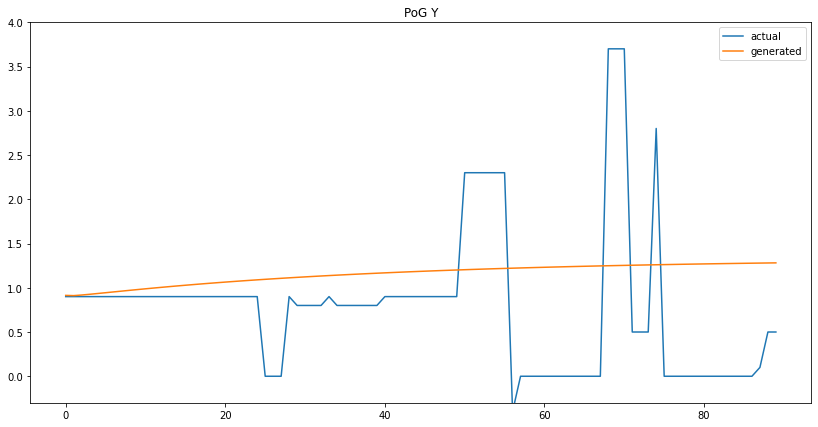

In [22]:
df = pd.DataFrame({"actual" : actual_seq[:,1].tolist(), "generated" : gen_seq[:,1].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="PoG Y")

PoG Z:

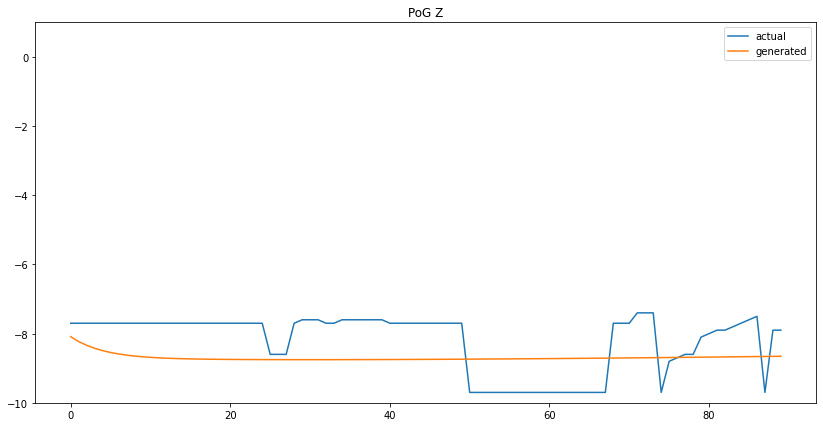

In [23]:
df = pd.DataFrame({"actual" : actual_seq[:,2].tolist(), "generated" : gen_seq[:,2].tolist()})
df.plot(figsize=(14,7), ylim=(-10,1), title="PoG Z")

Camera Position X:

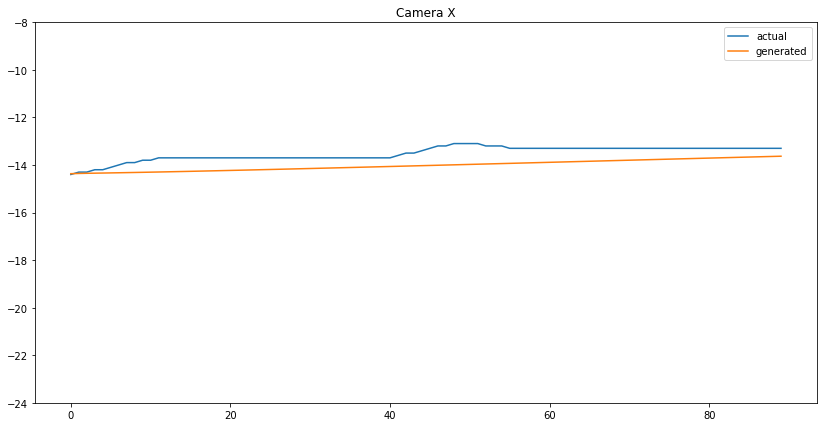

In [24]:
df = pd.DataFrame({"actual" : actual_seq[:,3].tolist(), "generated" : gen_seq[:,3].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="Camera X")

Camera Position Y:

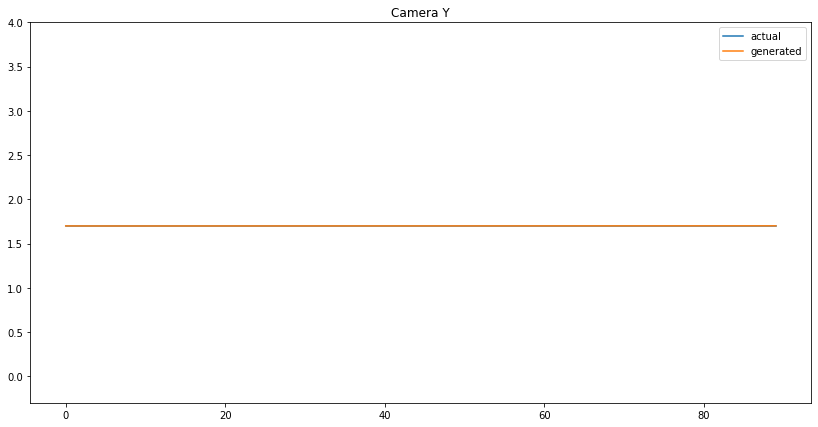

In [25]:
df = pd.DataFrame({"actual" : actual_seq[:,4].tolist(), "generated" : gen_seq[:,4].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="Camera Y")

Camera Position Z:

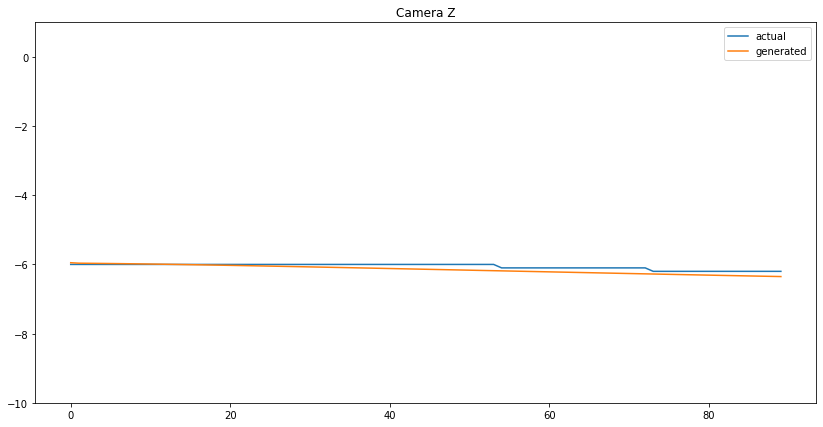

In [26]:
df = pd.DataFrame({"actual" : actual_seq[:,5].tolist(), "generated" : gen_seq[:,5].tolist()})
df.plot(figsize=(14,7), ylim=(-10,1), title="Camera Z")

Camera Vector X:

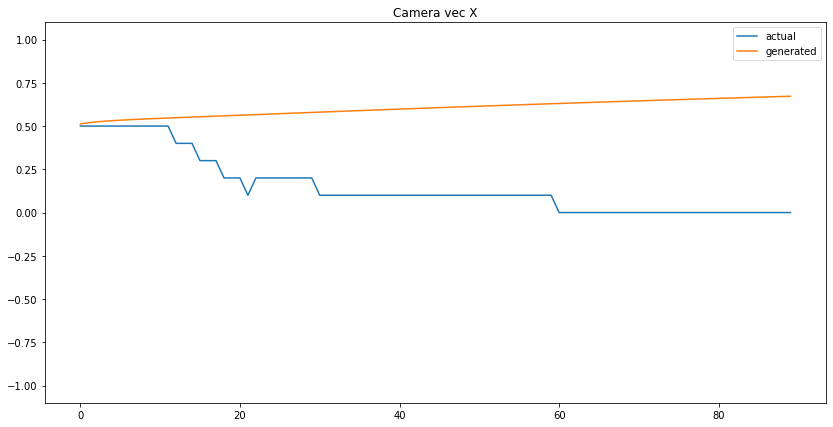

In [27]:
df = pd.DataFrame({"actual" : actual_seq[:,6].tolist(), "generated" : gen_seq[:,6].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec X")

Camera Vector Y:

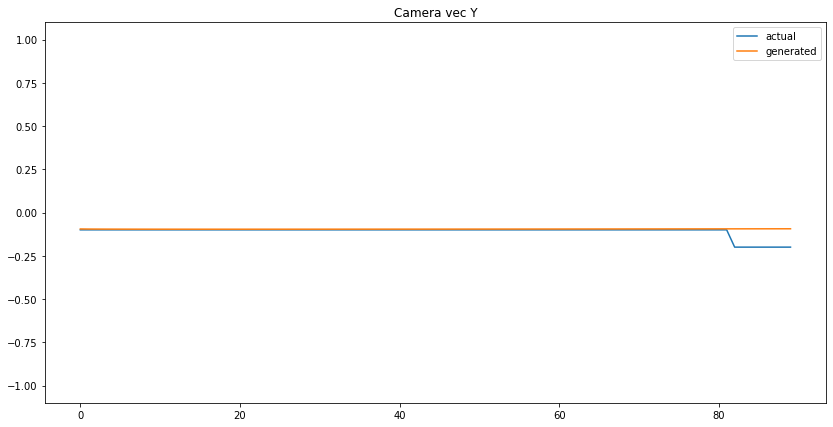

In [28]:
df = pd.DataFrame({"actual" : actual_seq[:,7].tolist(), "generated" : gen_seq[:,7].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec Y")

Camera Vector Z:

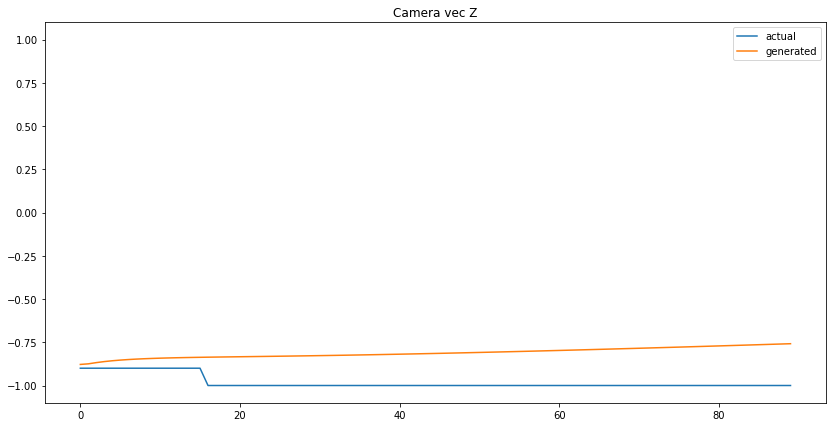

In [29]:
df = pd.DataFrame({"actual" : actual_seq[:,8].tolist(), "generated" : gen_seq[:,8].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec Z")

**Some obseravtions:**

By looking at some of the plots it is evident the model is attempting to fit a straight line of best fit for the future trajectories and is failing to learn shorter term deviations. While it does better at predicting subsequent visual attention and user orientation into the future it is clear there is still room for improvement

# Extensions



*   Use "Professor Forcing" a method for training seq2seq RNN based on the GAN framework.
*   Investigate "Attention" mechanisms for Encoder-Decoder model architectures.
*   Investigate using Reinforcement Learning to improve pre-trained Encoder-Decoder model architectures.

